## import libraries, packages, data

### libraries, packages

In [113]:
#importing libraries & packages
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
#display multiple outputs from cell 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# machine learning
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
from imblearn.over_sampling import ADASYN, SMOTE
from sklearn.feature_selection import SelectKBest, chi2
from sklearn import svm
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

### import clean data from part 1

In [135]:
# import Animal Control Incidents df
df = pd.read_csv('a_control.csv')

In [136]:
df.columns

Index(['incident_date', 'incident_time', 'dispatched_time', 'call_taker',
       'dispatcher', 'dispatched_other', 'dispatched_situation',
       'arrival_time', 'available_time', 'complainant_street', 'officer',
       'equipment_number', 'impound_number', 'impound_date', 'impound_time',
       'location', 'municipality', 'zip_code', 'species', 'breed', 'sex',
       'size', 'color', 'condition', 'temperment', 'disposition',
       'disposition_date', 'disposition_officer', 'service_type', 'inc_dt',
       'imp_dt', 'weekday', 'month'],
      dtype='object')

In [137]:
for col in ('month', 'weekday'):
    df[col] = df[col].astype(str)

In [138]:
df = df[['breed', 'size', 'color', 'month', 'species','municipality'
         , 'service_type', 'disposition']]

In [139]:
df.dropna(axis=0, inplace=True)

In [140]:
len(df)

39738

In [141]:
# # assign target
y = df["disposition"]

#remove target from features
df.drop(columns= ['disposition'], axis=1, inplace=True)

# dummy categorical features
#col_list = list(df.select_dtypes(include=['object']).columns)
col_list = list(df.columns)

# create dummies for categorical features, assign to X
df = pd.DataFrame(pd.get_dummies(data=df, drop_first=True
                   , prefix=col_list))
X = df


In [142]:

# X_train_d and y_train_d = using original standard test train spit dad
# that way, I can try out different resampling methods
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=3)

### functions

In [143]:
# print model report
def model_report(model, cm = True): 
    
    print('\nCross Validation Scoring:\n')
    
    train_score = model.score(X_train, y_train)
    print("train score: {:.4}%".format(train_score * 100))

    test_score = model.score(X_test, y_test)
    print("test score: {:.4}%".format(test_score * 100))
    
    if cm :

        cv_score = np.mean(cross_val_score(model, X, y, cv=3))
        print("cross val score: {:.4}%".format(cv_score * 100))

        print("\nClassification Report:")
        print(classification_report(actuals, predictions))

#         col_list = []
#         ind_list = []                     
#         for x in y_test.unique():
#             col_list.append('pred_'+ x)
#             ind_list.append('real_'+x)


        print('\nConfusion matrix:'.format(accuracy_score))
        display(pd.DataFrame(confusion_matrix(y_test, predictions)
                             #, columns=col_list, index=ind_list))
                ,columns=['pred doa','pred euth','pred spec_case', 'pred to owner','pred to wild', 'pred trans']
              , index=['real doa', 'real euth','real spec_case', 'real to owner', 'real to wild', 'real trans']))

    else:
        pass

In [144]:
def plot_matrix(classifier):

    disp = plot_confusion_matrix(classifier, X_test, y_test,
    #                                  display_labels=class_names,
                                     cmap=plt.cm.Blues,
                                     normalize='true'
                                )


# def plot_matrix(model):

#     class_names = ['dead on arrival', 'euthanized', 'special case/other'
#                    , 'returned to owner', 'returned to wild', 'tranferred to CAA']

#     fig, ax = plot_confusion_matrix(model
# #                                     colorbar=True,
# #                                     show_absolute=False,
# #                                     show_normed=True,
# #                                     class_names=class_names
#                                    )
#     plt.show()

## feature importance according to chi2 and xtra trees

## prep data

### resampling

Due to the imbalance of class data, it could be beneficial to resample to compensate for the missing data. Using smote to oversample, then random undersampling is a common practice in these circumstances



In [147]:
over = SMOTE(
   sampling_strategy='not majority'
    , random_state=3)
under = RandomUnderSampler(
    sampling_strategy='not minority',
    random_state=3)
steps = [
    ('o', over),
     ('u', under)
]
pipeline = Pipeline(steps=steps)
# # transform the dataset
X_train, y_train = pipeline.fit_resample(X_train, y_train)

In [148]:
print (y_train.value_counts())

special_caseother    23385
euthanized           23385
return_to_owner      23385
dead_on_arrival      23385
trans_caa            23385
return_to_wild       23385
Name: disposition, dtype: int64


## __modeling__

The most challenging obstacle I anticipate is overfitting, and poor recall for the minority groups. 

__basic base model__

In [149]:
lr = LogisticRegression(random_state=3)
lr.fit(X_train, y_train)
 
# Predict on training set
predictions = lr.predict(X_test)
actuals = y_test

model_report(lr)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=3, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


Cross Validation Scoring:

train score: 64.88%
test score: 91.26%
cross val score: 92.51%

Classification Report:
                   precision    recall  f1-score   support

  dead_on_arrival       0.00      0.00      0.00        13
       euthanized       0.00      0.00      0.00        27
  return_to_owner       0.00      0.00      0.00       305
   return_to_wild       0.85      0.99      0.92      1608
special_caseother       0.00      0.00      0.00       149
        trans_caa       0.93      0.97      0.95      5846

         accuracy                           0.91      7948
        macro avg       0.30      0.33      0.31      7948
     weighted avg       0.86      0.91      0.88      7948


Confusion matrix:


,pred doa,pred euth,pred spec_case,pred to owner,pred to wild,pred trans
real doa,0,0,0,4,0,9
real euth,0,0,0,9,0,18
real spec_case,0,0,0,13,0,292
real to owner,0,0,0,1598,0,10
real to wild,0,0,0,57,0,92
real trans,0,0,0,191,0,5655


### decision tree

default model

In [150]:
# initialize and fit default decision tree
dt_model = DecisionTreeClassifier(random_state=3)
dt_model.fit(X_train, y_train)
predictions = dt_model.predict(X_test)
#actuals = y_test

model_report(dt_model)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=3, splitter='best')


Cross Validation Scoring:

train score: 98.31%
test score: 86.07%
cross val score: 88.37%

Classification Report:
                   precision    recall  f1-score   support

  dead_on_arrival       0.00      0.00      0.00        13
       euthanized       0.07      0.11      0.08        27
  return_to_owner       0.12      0.16      0.13       305
   return_to_wild       0.93      0.96      0.95      1608
special_caseother       0.19      0.26      0.22       149
        trans_caa       0.93      0.89      0.91      5846

         accuracy                           0.86      7948
        macro avg       0.37      0.40      0.38      7948
     weighted avg       0.88      0.86      0.87      7948


Confusion matrix:


,pred doa,pred euth,pred spec_case,pred to owner,pred to wild,pred trans
real doa,0,1,1,3,2,6
real euth,2,3,1,3,2,16
real spec_case,0,1,48,9,1,246
real to owner,4,3,9,1545,10,37
real to wild,0,1,2,9,39,98
real trans,13,36,346,89,156,5206


#### grid searching

In [151]:
# set random search params
criterion=['gini','entropy']
max_leaf_nodes = [None,2,3,4,5,6,10,30]
max_features = ['auto', 'sqrt',20,50]
max_depth = [60,70,80,90,100,200]
min_samples_split = [2,3,5,6,7,8]
min_samples_leaf = [2]
bootstrap = [True, False]

random_grid = {'criterion':criterion,
               'max_leaf_nodes': max_leaf_nodes,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf
               }

# random grid search
dt_random = RandomizedSearchCV(estimator = dt_model
                               , param_distributions = random_grid
                               , n_iter = 150, cv = 3, verbose=3, error_score=0
                               , scoring=('recall_macro')
                               , random_state=3, n_jobs = -1)
# fit random search model
dt_random.fit(X_train, y_train);

print('best score: {:.4}%'.format(dt_random.best_score_ * 100));
print(dt_random.best_params_);

Fitting 3 folds for each of 150 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   46.3s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed: 10.3min finished


best score: 94.29%
{'min_samples_split': 3, 'min_samples_leaf': 2, 'max_leaf_nodes': None, 'max_features': 50, 'max_depth': 100, 'criterion': 'entropy'}


__grid search__

In [ ]:
# grid search params
param_grid_dt = {'criterion': ['gini', 'entropy'],
    'max_depth': [75,80,100,110],
    'min_samples_split': [2,3,4],
    'min_samples_leaf': [1,2,3,4],
     'max_features':['auto',30,40,50,60],
     'max_leaf_nodes':[None]
        }

# grid search
gs_dt = GridSearchCV(estimator=dt_model,
                    param_grid=param_grid_dt,
                     error_score=0,
                    scoring=('recall_macro'),
                    cv=5, n_jobs=-1, verbose=2)

# fitting grid search
gs_dt.fit(X_train, y_train);

# best parameters
print('Best score: {:.3}%'.format(gs_dt.best_score_ * 100));
print('params:\n', gs_dt.best_params_);

In [109]:
# using best params to fit model
dt_gs_model = DecisionTreeClassifier(criterion='gini',
                              max_depth=70,
                              max_features='sqrt',
                              max_leaf_nodes= None,
                               min_samples_leaf=1,
                               min_samples_split=2
                                
                                    )
dt_gs_model.fit(X_train, y_train)

predictions = dt_gs_model.predict(X_test)
actuals = y_test

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=70, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

#### final model

In [110]:
model_report(dt_gs_model)


Cross Validation Scoring:

train score: 96.33%
test score: 86.12%
cross val score: 88.18%

Classification Report:
                   precision    recall  f1-score   support

  dead_on_arrival       0.00      0.00      0.00        13
       euthanized       0.05      0.07      0.06        27
  return_to_owner       0.15      0.28      0.20       305
   return_to_wild       0.93      0.96      0.95      1608
special_caseother       0.29      0.24      0.26       149
        trans_caa       0.93      0.88      0.91      5846

         accuracy                           0.86      7948
        macro avg       0.39      0.41      0.40      7948
     weighted avg       0.89      0.86      0.87      7948


Confusion matrix:


,pred doa,pred euth,pred spec_case,pred to owner,pred to wild,pred trans
real doa,0,1,2,3,1,6
real euth,2,2,2,5,1,15
real spec_case,1,2,86,9,2,205
real to owner,4,4,8,1548,8,36
real to wild,0,1,5,8,36,99
real trans,12,27,465,93,76,5173


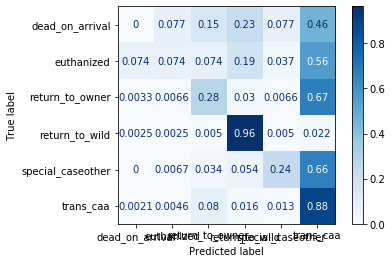

In [129]:
plot_matrix(dt_gs_model)

The test score didn't increase significantly, and the train score even decreased, but overfitting was avoided with the tuned model.

### Random Forest

---
__default model__

In [45]:
#initialize and fit random forest
rf_model = RandomForestClassifier(random_state=3)
rf_model.fit(X_train, y_train)

predictions = rf_model.predict(X_test)
#actuals = y_test

model_report(rf_model)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=3, verbose=0,
                       warm_start=False)


Cross Validation Scoring:

train score: 98.31%
test score: 89.04%
cross val score: 91.46%

Classification Report:
                   precision    recall  f1-score   support

  dead_on_arrival       0.00      0.00      0.00        13
       euthanized       0.07      0.07      0.07        27
  return_to_owner       0.13      0.10      0.11       305
   return_to_wild       0.93      0.97      0.95      1608
special_caseother       0.30      0.34      0.32       149
        trans_caa       0.93      0.93      0.93      5846

         accuracy                           0.89      7948
        macro avg       0.39      0.40      0.40      7948
     weighted avg       0.88      0.89      0.89      7948


Confusion matrix:


,pred doa,pred euth,pred spec_case,pred to owner,pred to wild,pred trans
real doa,0,1,0,3,1,8
real euth,1,2,0,4,1,19
real spec_case,0,1,30,9,3,262
real to owner,3,3,3,1562,9,28
real to wild,0,1,2,9,51,86
real trans,6,19,192,90,107,5432


#### grid searching

___
__Random Grid Search__

The default model is overfitting. Some ways to avoid overfitting with random forests are: increasing the n_estimators, reducing max features, limiting max depth, and increasing min leaf samples can help construct a more robust fit. Being that it did perform well despite the overfitting, I decided not to go crazy playing with the parameters.

In [152]:
# set random search params

n_estimators = [20,30,40,50,60]
min_weight_fraction_leaf=[0.0, 0.001, 0.0001]
min_samples_split = [2,3,4,5,6]
min_samples_leaf = [2,3,4,5,6]
min_impurity_split = [None]
min_impurity_decrease = [0.0,0.0001]
max_samples = [None]
max_leaf_nodes = [None]
max_features = ['auto', 7,8,15,20,50]
max_depth = [5,10,20,30,40,50,60]
criterion = ['entropy', 'gini']
bootstrap = [True, False]

# Create the random grid
random_grid = { 'n_estimators': n_estimators,
                 'min_weight_fraction_leaf': min_weight_fraction_leaf,
                 'min_samples_split': min_samples_split,
                 'min_samples_leaf': min_samples_leaf,
                 'min_impurity_split': min_impurity_split,
                 'min_impurity_decrease': min_impurity_decrease,
                 'max_samples': max_samples,
                 'max_leaf_nodes': max_leaf_nodes,
                 'max_features': max_features,
                  'max_depth': max_depth,
                 'criterion': criterion,
                 'bootstrap': bootstrap
              }

# fit and search random param combinations
rf_random = RandomizedSearchCV(estimator = rf_model
                               , param_distributions = random_grid
                               , n_iter = 150, cv = 3, verbose=10
                               , scoring = 'recall_macro',random_state=1, n_jobs = -1);
# Fit the random search model
rf_random.fit(X_train, y_train);

# print best parameters
print('best score: {:.4}%'.format(rf_random.best_score_ * 100));
print(rf_random.best_params_);

best score: 81.6%
{'n_estimators': 50, 'min_weight_fraction_leaf': 0.0001, 'min_samples_split': 4, 'min_samples_leaf': 4, 'min_impurity_split': 0.0, 'min_impurity_decrease': 0.0001, 'max_samples': 50, 'max_leaf_nodes': None, 'max_features': 8, 'max_depth': 40, 'criterion': 'gini', 'bootstrap': False}


___
__grid search__

In [153]:
param_grid_rf = {
        'n_estimators': [40,50]
          , 'min_samples_leaf': [4]
         , 'min_samples_split':[2,3,4]
        , 'max_samples': [30,40,50]
        , 'max_leaf_nodes':[None]
           , 'max_features': [8,9,10,15]
         , 'max_depth': [40,50]
         , 'criterion': ['gini']
          , 'bootstrap': [False]
}

# grid search
gs_rf = GridSearchCV(estimator=rf_model
                    ,param_grid=param_grid_rf
                    ,cv=3,refit=True,error_score=0
                     , scoring='recall_macro', n_jobs=-1, verbose=5
                    )

# fitting grid search
gs_rf.fit(X_train, y_train);

# best parameters
print('best score: {:.4}%'.format(gs_rf.best_score_ * 100));
print('params:\n', gs_rf.best_params_);

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 12.9min
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed: 22.7min finished


best score: 91.2%
params:
 {'bootstrap': False, 'criterion': 'gini', 'max_depth': 50, 'max_features': 9, 'max_leaf_nodes': None, 'max_samples': 50, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 50}


#### final model

___
__best model__

In [49]:
# fitting model using best params
rf_gs_model = RandomForestClassifier(
                                   bootstrap= False
                                    ,criterion= 'gini'
                                    , max_depth= 50
                                   , max_features = 9
                                   , max_leaf_nodes = None
                                   , max_samples = 50
                                     , min_samples_leaf = 4
                                   , min_samples_split = 4
                                    , n_estimators = 50
                                    );
rf_gs_model.fit(X_train, y_train);

predictions = rf_gs_model.predict(X_test);

# new model report
model_report(rf_gs_model)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=150, max_features=9,
                       max_leaf_nodes=17, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=4,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


Cross Validation Scoring:

train score: 62.73%
test score: 46.83%
cross val score: 91.15%

Classification Report:
                   precision    recall  f1-score   support

  dead_on_arrival       0.00      0.00      0.00        13
       euthanized       0.03      0.44      0.05        27
  return_to_owner       0.07      0.87      0.13       305
   return_to_wild       0.92      0.97      0.95      1608
special_caseother       0.32      0.40      0.35       149
        trans_caa       0.97      0.31      0.47      5846

         accuracy                           0.47      7948
        macro avg       0.39      0.50      0.33      7948
     weighted avg       0.91      0.47      0.55      7948


Confusion matrix:


,pred doa,pred euth,pred spec_case,pred to owner,pred to wild,pred trans
real doa,0,5,4,3,1,0
real euth,2,12,7,4,1,1
real spec_case,4,9,265,9,1,17
real to owner,14,7,2,1555,29,1
real to wild,5,22,21,8,60,33
real trans,44,369,3402,103,98,1830


Train score went down, but test score and cross val score went up, so at least the tuning constructed a more robust model.

### XGBoost

In [50]:
# initiate model
xgb_model = XGBClassifier(random_state=3)
xgb_model.fit(X_train, y_train)

predictions = xgb_model.predict(X_test)
# actuals = y_test

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=3,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [51]:
model_report(xgb_model)


Cross Validation Scoring:

train score: 77.2%
test score: 70.52%
cross val score: 92.48%

Classification Report:
                   precision    recall  f1-score   support

  dead_on_arrival       0.00      0.00      0.00        13
       euthanized       0.03      0.52      0.06        27
  return_to_owner       0.11      0.61      0.18       305
   return_to_wild       0.94      0.96      0.95      1608
special_caseother       0.50      0.36      0.42       149
        trans_caa       0.96      0.65      0.78      5846

         accuracy                           0.71      7948
        macro avg       0.42      0.52      0.40      7948
     weighted avg       0.91      0.71      0.78      7948


Confusion matrix:


,pred doa,pred euth,pred spec_case,pred to owner,pred to wild,pred trans
real doa,0,5,4,3,1,0
real euth,4,14,4,1,0,4
real spec_case,1,8,186,9,2,99
real to owner,29,10,1,1550,14,4
real to wild,5,24,6,7,53,54
real trans,46,366,1514,83,35,3802


#### grid searching

__random grid search__

In [52]:
#set random search params
learning_rate=[.15 ,.1,.05]
max_depth = [3,4]
min_child_weight = [.5, 1,1.5]
n_estimators = [90,100, 110]


random_grid = {
               'learning_rate':learning_rate,
               'max_depth': max_depth,
               'min_child_weight':min_child_weight
              'n_estimators': n_estimators
              }

# searching random params
xgb_random = RandomizedSearchCV(estimator = xgb_model
                               , param_distributions = random_grid
                               , n_iter = 10, cv = 3, verbose=10, scoring='recall_macro'
                               , random_state=3, n_jobs = -1)
# fit random search model
xgb_random.fit(X_train, y_train)
print('best accuracy: {:.4}%'.format(xgb_random.best_score_ * 100));
print(xgb_random.best_params_);

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed: 201.8min
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed: 201.8min
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed: 201.8min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed: 201.8min
[Parallel(n_jobs=-1)]: Done   9 out of  12 | elapsed: 201.8min remaining: 67.3min


KeyboardInterrupt: 

#### grid search

In [ ]:
param_grid_xgb = [
    {
#         'xgb_model__min_samples_split':[2,3],
      #   'xbg_model__gamma':[0.01,0.1,.05],
        'xgb_model__min_child_weight': [0.9, 1.0, 1.2],
    'xgb_model__learning_rate': [0.009, 0.01, 0.011 ]
    #'xgb_model__n_estimators': [150,200,250],
    #'xgb_model__max_depth': [2,3]
    }
]

# Construct Grid Search
gs_xgb = GridSearchCV(estimator=xgb_model,
                    param_grid=param_grid_xgb,
                    scoring='recall_macro',random_state=3,
                    cv=3, n_jobs=-1, verbose=10)

# Fit using grid search
gs_xgb.fit(X, y)

# Best accuracy and parameters
print('best score: {:.3}%'.format(gs_xgb.best_score_ * 100))
print('params:\n', gs_xgb.best_params_);

In [131]:
# fit using best params
xgb_gs_model = XGBClassifier(learning_rate=0.009,
                           #  max_depth=3,
                             min_child_weight=1
                          #   n_estimators=90
                            )
xgb_gs_model.fit(X_train, y_train)

predictions = xgb_gs_model.predict(X_test)

model_report(xgb_gs_model)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.009, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


Cross Validation Scoring:

train score: 59.36%
test score: 48.34%
cross val score: 92.32%

Classification Report:
                   precision    recall  f1-score   support

  dead_on_arrival       0.00      0.00      0.00        13
       euthanized       0.03      0.56      0.06        27
  return_to_owner       0.08      0.88      0.14       305
   return_to_wild       0.94      0.96      0.95      1608
special_caseother       0.62      0.30      0.41       149
        trans_caa       0.96      0.34      0.50      5846

         accuracy                           0.48      7948
        macro avg       0.44      0.50      0.34      7948
     weighted avg       0.91      0.48      0.57      7948


Confusion matrix:


,pred doa,pred euth,pred spec_case,pred to owner,pred to wild,pred trans
real doa,0,5,4,3,1,0
real euth,2,15,4,1,0,5
real spec_case,2,10,268,9,1,15
real to owner,39,10,2,1536,8,13
real to wild,3,36,16,6,45,43
real trans,63,431,3275,81,18,1978


### AdaBoost

In [154]:
#initialize and fit default model
ada_model = AdaBoostClassifier(random_state=3)
ada_model.fit(X_train, y_train)

predictions = ada_model.predict(X_test)
# actuals = y_test

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=3)

___
__Default Model__

In [155]:
model_report(ada_model)


Cross Validation Scoring:

train score: 57.81%
test score: 53.54%
cross val score: 89.85%

Classification Report:
                   precision    recall  f1-score   support

  dead_on_arrival       0.00      0.00      0.00        13
       euthanized       0.04      0.22      0.07        27
  return_to_owner       0.08      0.78      0.14       305
   return_to_wild       0.93      0.96      0.95      1608
special_caseother       0.13      0.43      0.20       149
        trans_caa       0.96      0.41      0.58      5846

         accuracy                           0.54      7948
        macro avg       0.36      0.47      0.32      7948
     weighted avg       0.90      0.54      0.62      7948


Confusion matrix:


,pred doa,pred euth,pred spec_case,pred to owner,pred to wild,pred trans
real doa,0,0,4,3,5,1
real euth,0,6,6,1,11,3
real spec_case,0,4,237,10,3,51
real to owner,7,27,2,1546,23,3
real to wild,3,4,15,16,64,47
real trans,15,109,2854,83,383,2402


#### grid searching

__Random Grid Search__

In [156]:
#set random search params
learning_rate= [.00001,.001,.01,.1,1, 1.5]

n_estimators = [1,5,10,50,100, 200]

random_grid = {'learning_rate':learning_rate,
               'n_estimators': n_estimators
              }

In [158]:
#random grid search
ada_random = RandomizedSearchCV(estimator = ada_model
                               , param_distributions = random_grid
                               , n_iter = 10, cv = 3, verbose=2
                               , scoring='recall_macro', random_state=3, n_jobs = -1)
# Fit the random search model
ada_random.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 22.7min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                                base_estimator=None,
                                                learning_rate=1.0,
                                                n_estimators=50,
                                                random_state=3),
                   iid='deprecated', n_iter=10, n_jobs=-1,
                   param_distributions={'learning_rate': [1e-05, 0.001, 0.01,
                                                          0.1, 1, 1.5],
                                        'n_estimators': [1, 5, 10, 50, 100,
                                                         200]},
                   pre_dispatch='2*n_jobs', random_state=3, refit=True,
                   return_train_score=False, scoring='recall_macro', verbose=2)

In [159]:
ada_random.best_params_

{'n_estimators': 200, 'learning_rate': 0.1}

___
__grid search__

In [ ]:
#grid search params and fitting grid search
param_grid_ada = [
    {'n_estimators': [190,200,250],
    'learning_rate': [0.09, 0.1, 0.11]}
]

# Construct Grid Search
gs_ada = GridSearchCV(estimator=ada_model,
                    param_grid=param_grid_ada,
                    scoring='recall_macro',
                    cv=5, n_jobs=-1, verbose=10)

# Fit using grid search
gs_ada.fit(X_train, y_train)

# Best accuracy and parameters
print('best recall: {:.4}%'.format(gs_ada.best_score_ * 100))
print('params:\n', gs_ada.best_params_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed: 11.1min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 19.2min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 28.5min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 34.9min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 55.6min
[Parallel(n_jobs=-1)]: Done  43 out of  45 | elapsed: 82.9min remaining:  3.9min


In [ ]:
# fit best params
ada_gs_model = AdaBoostClassifier(n_estimators=100,
                                   learning_rate=1.1)
ada_gs_model.fit(X_train, y_train)

predictions = ada_gs_model.predict(X_test)

#### final model

__best model__

In [ ]:
model_report(ada_gs_model)

### gradient boost

In [ ]:
#initialize and fit gradient boost
gbt_model = GradientBoostingClassifier(random_state=3)
gbt_model.fit(X_train, y_train)

predictions = gbt_model.predict(X_test)
# actuals = y_test

__default model__

In [ ]:
#baseline model report
model_report(gbt_model)

__grid searching__

__random grid search__

In [ ]:
# setting parameters for random search
learning_rate=[0.05,.1, .15]
loss = ['deviance', 'exponential']
max_depth = [None,2,3,4] 
n_estimators = [50,60,70]
min_samples_split = [2,3,4]
min_samples_leaf = [1,2,3]
min_weight_fraction_leaf = [0,0.0001]

random_grid = {'learning_rate':learning_rate,
               'loss': loss,
               'max_depth': max_depth,
               'n_estimators': n_estimators,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'min_weight_fraction_leaf': min_weight_fraction_leaf
               }

#searching random params
gbt_random = RandomizedSearchCV(estimator = gbt_model
                               , param_distributions = random_grid
                               , n_iter = 20, cv = 3, verbose=10
                               , scoring='recall_macro', random_state=3, n_jobs = -1)
# fit random search model
gbt_random.fit(X_train, y_train)

In [ ]:
print('best accuracy: {:.4}%'.format(gbt_random.best_score_ * 100));
print(gbt)_random.best_params_)

__grid search__

In [ ]:
# grid search params and run search
param_grid_gbt = [
    {'n_estimators': [40,60,100,120],
     'min_weight_fraction_leaf':[0.001, 0.01, 0.0001],
    'learning_rate': [0.1, .001],
    'min_samples_split': [2,3,4],
    'min_samples_leaf': [2,3,5,6],
    'max_depth': [2,3]
    }
]

# grid search
gs_gbt = GridSearchCV(estimator=gbt_model,
                    param_grid=param_grid_gbt,
                    scoring='recall_macro',
                    cv=3, n_jobs=-1, verbose=10)

# fit grid search
gs_gbt.fit(X_train, y_train)

# best params
print('best accuracy: {:.4}%'.format(gs_gbt.best_score_ * 100))
print('params:\n', gs_gbt.best_params_)

In [ ]:
# fitting best params
gbt_gs_model = GradientBoostingClassifier(learning_rate=0.1,
                                         max_depth=2,
                                         min_samples_leaf=2,
                                         min_samples_split=2,
                                         min_weight_fraction_leaf=0.01,
                                         n_estimators=60)
gbt_gs_model.fit(X_train, y_train)

predictions = gbt_gs_model.predict(X_test)

#### final model

__best model__

In [ ]:
# new model report
model_report(gbt_gs_model)

### SVM

In [ ]:
svm_model = svm.SVC(random_state=3)
svm_model.fit(X_train, y_train)

predictions = svm_model.predict(X_test)
# actuals = y_test

___
__default model__

In [ ]:
model_report(svm_model, cm=False)

#### grid searching

__random grid search__

In [ ]:
# set random search params
clf_C = [0.07,0.1,1.0, 1.03]
clf_gamma = [0.005,0.001,0.01, 0.1]
clf_kernel = ['rbf', 'linear']

random_grid = {
               'C': clf_C,
               'gamma': clf_gamma,
               'kernel': clf_kernel
               }

# fit and search random param combinations
svm_random = RandomizedSearchCV(estimator = svm_model
                               , param_distributions = random_grid
                               , n_iter = 12 , cv = 3, verbose=10
                               , scoring='recall_macro', random_state=3, n_jobs = -1)
# Fit the random search model
svm_random.fit(X_train, y_train)

In [ ]:
print('best accuracy: {:.4}%'.format(svm_random.best_score_ * 100));
print(svm_random.best_params_)

___
__grid search__

In [ ]:
# Set grid search params
param_grid_svm = [
 
  {'C': [1.0, 1.01, 1.03], 'gamma': [0.008, 0.01, 0.012]
   , 'kernel': ['rbf', 'linear']
  }]
 

# Construct grid search
gs_svm = GridSearchCV(estimator=svm_model,
            param_grid=param_grid_svm,scoring='recall_macro',
            cv=5, verbose=10, return_train_score = True)

# Fit using grid search
gs_svm.fit(X_train, y_train)

# Best accuracy
print('best score: {:.4}%'.format(gs_svm.best_score_ * 100));
print('\nBest params:\n', gs_svm.best_params_)

In [ ]:
svm_gs_model = svm.SVC(C=1.03
                       ,gamma=0.008
                        ,kernel='rbf'
                             )
svm_gs_model.fit(X_train, y_train)

predictions = svm_gs_model.predict(X_test)

#### final model

__best model__

In [ ]:
model_report(svm_gs_model, cm=False)